In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tqdm.notebook import tqdm
import talib
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import plotly.express as px
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from yahoofinancials import YahooFinancials
import pandas_datareader as web
%matplotlib inline

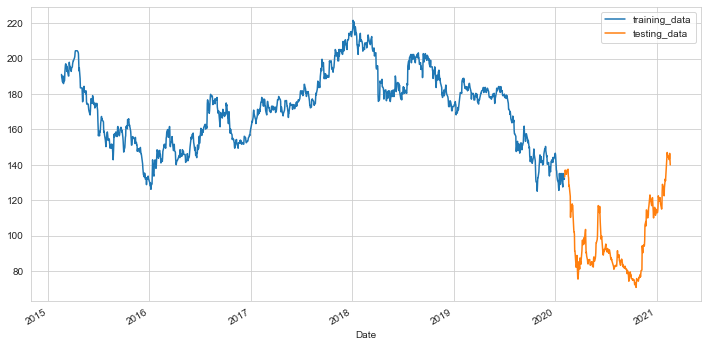

In [2]:
stock_data = web.DataReader('kbank.bk', 'yahoo', '2015-01-01', '2026-01-01')
stock_data['rsi'] = talib.RSI(stock_data['Adj Close'])
stock_data['mom'] = talib.MOM(stock_data['Adj Close'])
stock_data['adx'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data['macd'], stock_data['macd sig'], _ = talib.MACD(stock_data['Adj Close'])
stock_data.dropna(axis=0, inplace=True)

train_data = stock_data.iloc[:-253]
test_data = stock_data.iloc[-253:]

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(12,6));
test_data['Adj Close'].plot(label='testing_data');
plt.legend();

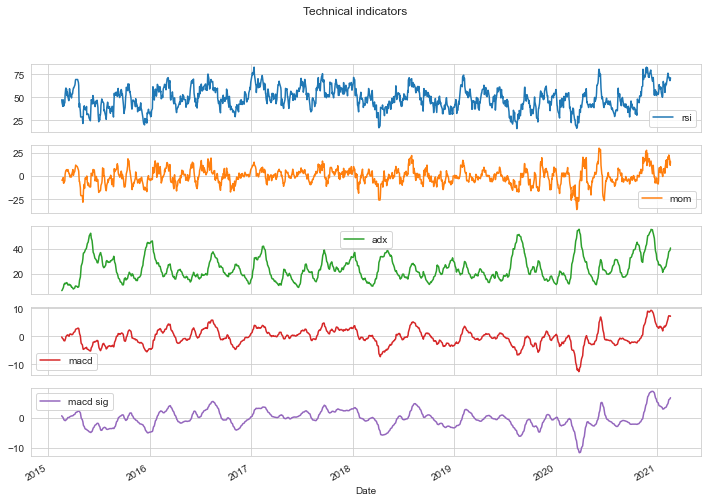

In [18]:
stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig']].plot(subplots=True, figsize=(12,8), title='Technical indicators');

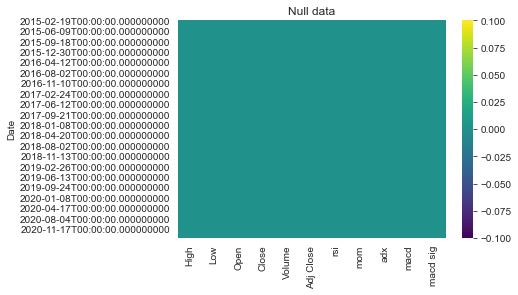

In [19]:
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Null data');

In [20]:
class NeuralNetwork(nn.Module):
    '''
    Network for predict action trading 
    '''
    def __init__(self, input_sz, action_sz):
        super(NeuralNetwork, self).__init__()
        self.input_sz = input_sz
        self.action_sz = action_sz
        self.fc1 = nn.Linear(input_sz, 30)
        self.fc2 = nn.Linear(30, 40)
        self.out = nn.Linear(40, action_sz)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.out(x)
        return q_values

In [21]:
class DQNAgent:
    '''Agent'''
    def __init__(self, input_sz, action_sz, discount_factor):
        self.model = NeuralNetwork(input_sz, action_sz)
        #self.target_model = NeuralNetwork(input_sz, action_sz)
        self.memory = ExperienceReplayMemory(capacity=10000)
        self.discount_factor = discount_factor
        self.reward_window = []
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.last_state = torch.Tensor(input_sz).unsqueeze(0) #shape [1, 5]
        self.last_action = 0
        self.last_raward = 0
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 128
        self.action_sz = action_sz
        self.criterion = nn.MSELoss()
        self.losses = []
        
    
    def get_action(self, state):
        '''
        Epsilon-greedy selection
        '''
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_sz)
        
        q_values_probs = F.softmax(self.model(state.detach()), dim=0)
        return q_values_probs.argmax()
    
    
    def train(self, batch_state, batch_next_state, batch_action, batch_reward):
        outputs = self.model(batch_state)
        next_outputs = self.model(batch_next_state).detach() #Q(s',a')
        argmax_target = torch.argmax(next_outputs, dim=1)
        target = batch_reward + self.discount_factor * next_outputs.max(1)[0] #target = reward + gamma*Q(s',a')
        target_full = torch.zeros_like(outputs)
        target_full.copy_(outputs)
        for i in range(len(batch_state)):
            target_full[i][argmax_target[i]] = target[i]
        loss = self.criterion(outputs, target_full)
        if np.isnan(loss.item()):
            print('stop-----------------')
            print('\n\n')
        self.losses.append(loss.item()) #loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
    def update(self, reward, new_state):
        new_state = torch.tensor(new_state[0]).float().unsqueeze(0)
        self.memory.push((self.last_state,
                        new_state,
                        torch.LongTensor([int(self.last_action)]),
                        torch.Tensor([self.last_raward])))
        action = self.get_action(new_state)
        
        if len(self.memory.memory) > self.batch_size:
            #sample batch event from memory (experience replay)
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(self.batch_size)
            #learn
            self.train(batch_state, batch_next_state, batch_action, batch_reward)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.last_action = action
        self.last_state = new_state
        self.last_raward = reward
        self.reward_window.append(reward)
        if len(self.reward_window) > self.batch_size:
            del self.reward_window[0]
        return action
    

    def score(self):
        return sum(self.reward_window) / (len(self.reward_window) + 1.)
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    }, 'trading1.pth')
        print('=> Saved!!!...')
        

    def load(self):
        if os.path.isfile('trading1.pth'):
            print("==> loading parameters!")
            checkpoint = torch.load('trading1.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.model.eval()
            print("done !")
        else:
            print("no parameters found...")
        
   


In [22]:
class SingleStock:
    '''
    Single Stock for trading 

    '''
    def __init__(self, data, capital):
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 8  # [stock price, stock_owned, cash_in_hand, rsi, mom, adx, macd, macd_sig]
        self.save_position = []
        self.save_port_val = []
        self.save_cash = []
        self.stock_value = []
        self.action_space = [0, 1, 2]
        self.sell_buy = None
        self.save_stock_price = []
        self.rsi = None
        self.mom = None
        self.adx = None
        self.macd = None
        self.masc_sig = None
        self.save_reward = None
        self.reset()

    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi
        vector[4] = self.mom
        vector[5] = self.adx
        vector[6] = self.macd
        vector[7] = self.masc_sig
        return vector

    
    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital]
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self.save_stock_price = [self.stock_price]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.save_reward = [0]
        return self.state_vector()

    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand

    def trade(self, action):
        
        assert action in range(len(self.action_space))

        position = self.action_space[action]

        
        if position > 0 and self.cash_in_hand >= (position * self.stock_price):
            #buy

            self.cash_in_hand -= (position * self.stock_price)
            self.stock_owned += position
            self.sell_buy.append('buy')
                           
        elif position < 0 and self.stock_owned >= abs(position):
            #sell

            self.stock_owned -= abs(position)
            self.cash_in_hand += abs(position * self.stock_price)
            self.sell_buy.append('sell')
                      
        else:
            self.sell_buy.append('hold')

                
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)

    def step(self, action):
        assert action in range(len(self.action_space))

        prev_val = self.port_val()
        self.current_step += 1
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.trade(action)
        current_val = self.port_val()
        reward = current_val 
        self.save_reward.append(reward)
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                'current_val': current_val,
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy
                }
        return self.state_vector(), reward, done, info
    
    
def get_scaler(env):
    states = []
    for i in range(env.n_step):
        action = np.random.choice(range(len(env.action_space)))
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler



In [23]:
class ExperienceReplayMemory:
    '''
    Memory storage for experience replay
    '''
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
            
    def sample(self, batch_size):
        '''Sample event from memory (len = batch size)'''
        # [batch_state, batch_next_state, batch_action, batch_reward]
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)

In [24]:
num_episodes = 200
capital = 100000
env = SingleStock(train_data, capital)
state_size = env.state_dim
action_size = len(env.action_space)
torch.manual_seed(101)
agent = DQNAgent(state_size, action_size, 0.9)
scaler = get_scaler(env)

  0%|          | 0/200 [00:00<?, ?it/s]

episode: 1/200, episode end value: 93601.26
episode: 2/200, episode end value: 99477.73
episode: 3/200, episode end value: 99448.50
episode: 4/200, episode end value: 99530.66
episode: 5/200, episode end value: 99500.92
episode: 6/200, episode end value: 99618.17
episode: 7/200, episode end value: 99292.07
episode: 8/200, episode end value: 99554.87
episode: 9/200, episode end value: 99481.11
episode: 10/200, episode end value: 99355.29
episode: 11/200, episode end value: 99636.53
episode: 12/200, episode end value: 99450.89
episode: 13/200, episode end value: 99824.31
episode: 14/200, episode end value: 99109.15
episode: 15/200, episode end value: 99407.30
episode: 16/200, episode end value: 99313.23
episode: 17/200, episode end value: 99584.38
episode: 18/200, episode end value: 99527.19
episode: 19/200, episode end value: 99588.08
episode: 20/200, episode end value: 99360.28
episode: 21/200, episode end value: 99534.82
episode: 22/200, episode end value: 99690.67
episode: 23/200, ep

episode: 182/200, episode end value: 99463.70
episode: 183/200, episode end value: 99510.05
episode: 184/200, episode end value: 99324.56
episode: 185/200, episode end value: 99585.80
episode: 186/200, episode end value: 99380.84
episode: 187/200, episode end value: 99776.44
episode: 188/200, episode end value: 99510.38
episode: 189/200, episode end value: 99559.64
episode: 190/200, episode end value: 99768.83
episode: 191/200, episode end value: 99821.09
episode: 192/200, episode end value: 99457.60
episode: 193/200, episode end value: 99443.43
episode: 194/200, episode end value: 99278.75
episode: 195/200, episode end value: 99470.68
episode: 196/200, episode end value: 99661.43
episode: 197/200, episode end value: 99722.44
episode: 198/200, episode end value: 99569.63
episode: 199/200, episode end value: 99518.93
episode: 200/200, episode end value: 99555.26
=> Saved!!!...
average reward: 99508.28, min: 93601.26, max: 99879.50


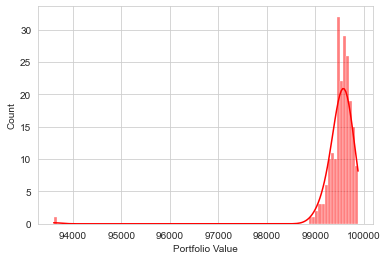

In [25]:
#train

portfolio_value = []
reward = []
total_reward = np.zeros(num_episodes)
for e in tqdm(range(num_episodes)):
 
    last_state = env.reset()
    last_reward = 0
    done = False
    scores = []
    while not done:
        last_state = scaler.transform([last_state])
        action = agent.update(last_reward, last_state)
        scores.append(agent.score())
        last_state, last_reward, done, info = env.step(action) 
        total_reward[e] += last_reward
        
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {info['portfolio_value'][-1]:.2f}")
    portfolio_value.append(info['portfolio_value'][-1]) 
    
       
agent.save()
losses = agent.losses

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
sns.histplot(portfolio_value, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

<AxesSubplot:>

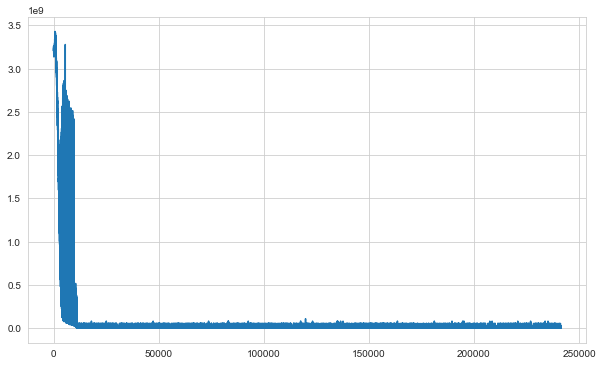

In [30]:
pd.Series(losses).plot(figsize=(10,6))

<AxesSubplot:>

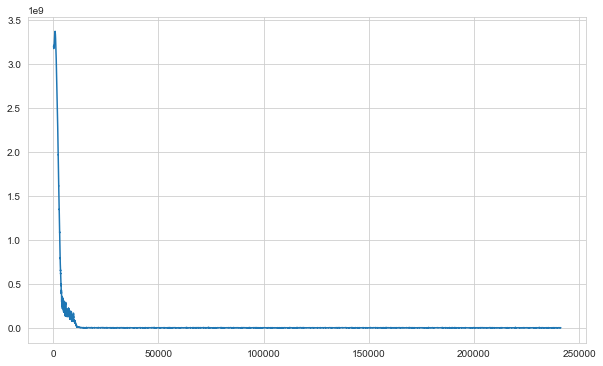

In [31]:
pd.Series(losses).rolling(128).mean().plot(figsize=(10,6))

<ipython-input-32-a675ab05a006>:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



<AxesSubplot:>

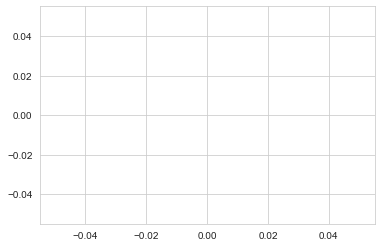

In [32]:
pd.Series(scores).plot()

In [34]:
env = SingleStock(test_data, capital)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size,0.9)

last_state = env.reset()
last_reward = 0
done = False
scores = []
agent.load()

while not done:
    last_state = scaler.transform([last_state])
    last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.model(last_state).argmax().item()
    last_state, last_reward, done, info = env.step(action)



print(f"Portfolio Value: {info['portfolio_value'][-1]}")
print(f"Sell: {env.sell_buy.count('sell')} times, Buy: {env.sell_buy.count('buy')} times")

no parameters found...
Portfolio Value: 124085.47769165039
Sell: 0 times, Buy: 252 times


In [11]:
a = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
b = torch.zeros_like(a)

In [12]:
b

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [13]:
b.clone(a)

TypeError: clone() takes 0 positional arguments but 1 was given

In [106]:
a[0][1] = 77
a[1][2] = np.nan

In [107]:
b

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [108]:
a

tensor([[ 1., 77.,  3.],
        [ 4.,  5., nan]])

In [109]:
criterion = nn.MSELoss()

In [112]:
criterion(a,b)

tensor(nan)

In [118]:
np.isnan(criterion(a,b).item())

True

In [ ]:
np.isinf